In [17]:
import torch
from datasets import load_dataset
from safetensors.torch import load_file
from lora import LoRAModel
from transformers import AutoModelForImageClassification, AutoImageProcessor

hf_dataset = "food101"
hf_model_name = "google/vit-base-patch16-224"

In [2]:
dataset = load_dataset(hf_dataset)
labels = dataset["train"].features["label"].names
processor = AutoImageProcessor.from_pretrained(hf_model_name, use_fast=True)

## Load Adapter Only

We have two files that we saved, one that has only the parameters we trained (like the LoRA A,B Matricies and the Classifier Head) and the second is the merged weights for the full model. Lets first try loading our adapter weights to make sure it works! This means we need to load our model as a LoRA model and then pull those weights in:

In [4]:
model = AutoModelForImageClassification.from_pretrained(hf_model_name, 
                                                        num_labels=len(labels), 
                                                        ignore_mismatched_sizes=True)
lora_model = LoRAModel(model=model, 
                       rank=8, 
                       lora_alpha=8, 
                       use_rslora=True, 
                       target_modules=["query", "key", "value", "dense", "projection"],
                       exclude_modules=["classifier"],
                       lora_dropout=0.0)

lora_model.load_model(path="work_dir/LoRAImageClassifier/food_adapter_checkpoint.safetensors")
lora_model.eval()

print("Loaded All Keys")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initial Parameters : 85876325 || LoRA Parameters : 1691237 || Trainable Proportion : 1.97%
Loaded All Keys


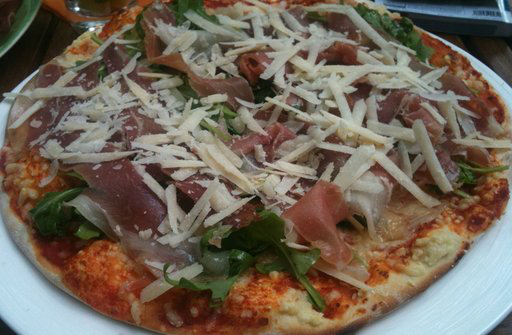

Ground Truth: pizza


In [31]:
def grab_sample(sample_idx):
    sample = dataset["validation"][sample_idx]
    image, label_idx = sample["image"], sample["label"]
    label = labels[label_idx]
    image_tensor = processor(image)

    return image, label, image_tensor
    
image, label, image_tensor = grab_sample(2500)
display(image)
print("Ground Truth:", label)

In [32]:
with torch.no_grad():
    adapter_logits = lora_model(**image_tensor)["logits"]

prediction = torch.argmax(adapter_logits)
print("Prediction:", labels[prediction])

Prediction: pizza


### Load the Full Model 

Instead of our adapter weights, we can now load our full model instead!

In [33]:
model = AutoModelForImageClassification.from_pretrained(hf_model_name, 
                                                        num_labels=len(labels), 
                                                        ignore_mismatched_sizes=True)
state_dict = load_file("work_dir/LoRAImageClassifier/full_food_checkpoint.safetensors")

### Clean Up the State Dict ###
state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}

model.load_state_dict(state_dict)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [34]:
with torch.no_grad():
    full_logits = model(**image_tensor)["logits"]

prediction = torch.argmax(full_logits)
print("Prediction:", labels[prediction])

Prediction: pizza
